In [63]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
from folium.plugins import HeatMap
from shapely.geometry import Point, shape
from shapely.wkt import loads
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.patches as mpatches
from IPython.display import Image

In [26]:
# Load CTA Stops Data
cta_data = pd.read_csv("cleaned_cta_data.csv")

# Load Employment Data
employment_data = pd.read_csv("census.csv")

# Load Community Areas Data
community_areas = pd.read_csv("CommAreas_20250314.csv")

In [47]:
# Fix column name issue by stripping whitespace
df_employment = employment_data.rename(columns=lambda x: x.strip())

# Convert numeric columns to appropriate data types
df_employment['PER CAPITA INCOME'] = pd.to_numeric(df_employment['PER CAPITA INCOME'], errors='coerce')
df_employment['PERCENT AGED 16+ UNEMPLOYED'] = pd.to_numeric(df_employment['PERCENT AGED 16+ UNEMPLOYED'], errors='coerce')

# Rename unemployment column for consistency
df_employment.rename(columns={'PERCENT AGED 16+ UNEMPLOYED': 'Unemployment Rate'}, inplace=True)

# Drop NaN values before converting Community Area Number
df_employment = df_employment.dropna(subset=['Community Area Number'])
df_employment['Community Area Number'] = df_employment['Community Area Number'].astype(float).astype(int).astype(str)
community_areas['AREA_NUMBE'] = community_areas['AREA_NUMBE'].astype(int).astype(str)

# Compute centroids for community areas
community_areas_gdf = gpd.GeoDataFrame(community_areas, geometry=community_areas['the_geom'].apply(lambda x: loads(x) if isinstance(x, str) else None))
community_areas_gdf = community_areas_gdf.dropna(subset=['geometry'])  # Remove invalid geometries
community_areas_gdf['centroid'] = community_areas_gdf.geometry.centroid
community_areas_gdf['Latitude'] = community_areas_gdf['centroid'].y
community_areas_gdf['Longitude'] = community_areas_gdf['centroid'].x

# Merge employment data with community areas
employment_with_geo = df_employment.merge(community_areas_gdf, left_on='Community Area Number', right_on='AREA_NUMBE', how='left')

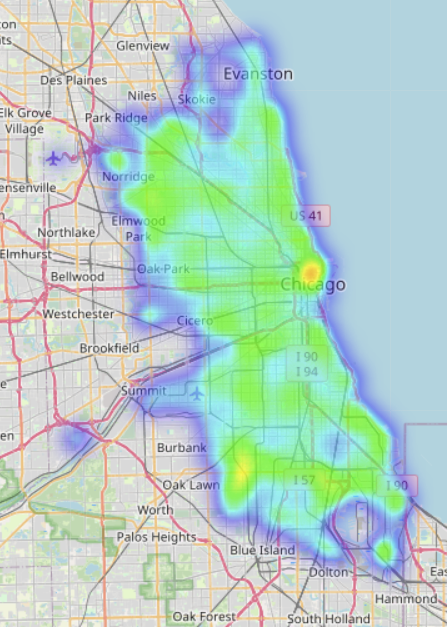

In [65]:
# 1. Heatmap of Public Transit Stops
chicago_map = folium.Map(location=[41.8781, -87.6298], zoom_start=12)
heat_data = [[row['Latitude'], row['Longitude']] for _, row in cta_data.iterrows()]
HeatMap(heat_data, radius=10).add_to(chicago_map)
chicago_map.save("cta_heatmap.html")
Image(filename="cta_heatmap.png")

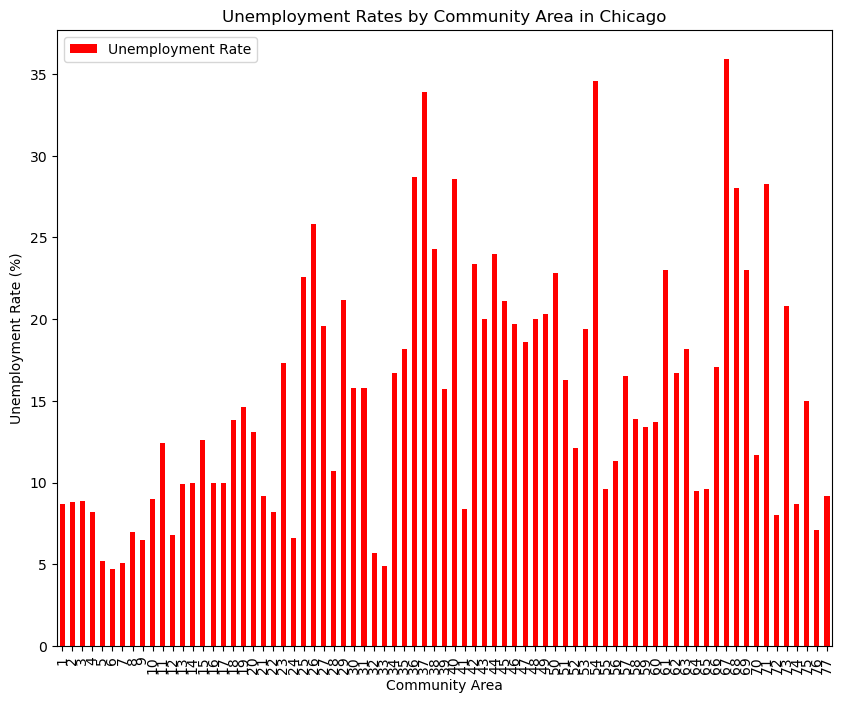

In [49]:
# 2. Choropleth Map of Unemployment Rates
fig, ax = plt.subplots(figsize=(10, 8))
employment_with_geo.plot(x='Community Area Number', y='Unemployment Rate', kind='bar', ax=ax, color='red')
plt.title("Unemployment Rates by Community Area in Chicago")
plt.xlabel("Community Area")
plt.ylabel("Unemployment Rate (%)")
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.savefig("unemployment_choropleth.png")

/tmp/ipykernel_621/1433454021.py:5: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  cta_gdf = gpd.sjoin(cta_gdf, community_areas_gdf[['geometry', 'AREA_NUMBE']], how='left', predicate='within')


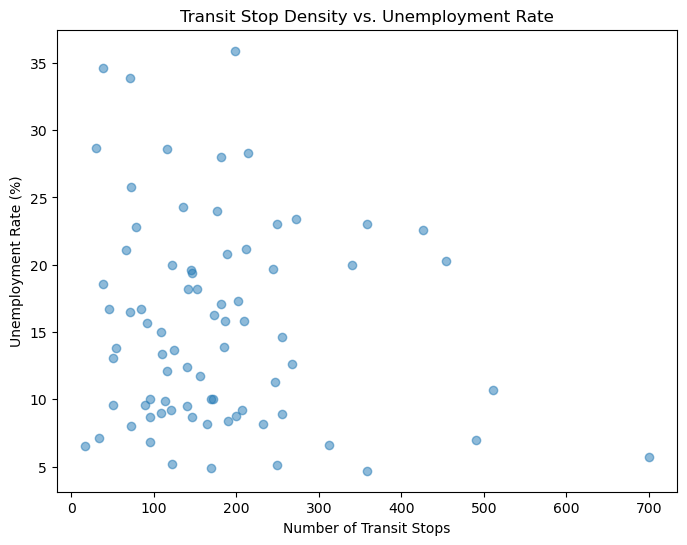

In [67]:
# Convert CTA Data to GeoDataFrame
cta_gdf = gpd.GeoDataFrame(cta_data, geometry=gpd.points_from_xy(cta_data.Longitude, cta_data.Latitude), crs="EPSG:4326")

# Spatial join: Match CTA stops to community areas
cta_gdf = gpd.sjoin(cta_gdf, community_areas_gdf[['geometry', 'AREA_NUMBE']], how='left', predicate='within')

# Rename to match employment data
cta_gdf.rename(columns={'AREA_NUMBE': 'Community Area Number'}, inplace=True)

# Convert to string to match merge keys
cta_gdf['Community Area Number'] = cta_gdf['Community Area Number'].astype(str)

# Group by Community Area
cta_grouped = cta_gdf.groupby('Community Area Number').size().reset_index(name='Transit Stops')

# Merge corrected transit stop count
data_merged = employment_with_geo.merge(cta_grouped, on='Community Area Number', how='left').fillna(0)

# Replot with corrected transit stop counts
plt.figure(figsize=(8,6))
plt.scatter(data_merged['Transit Stops'], data_merged['Unemployment Rate'], alpha=0.5)
plt.xlabel("Number of Transit Stops")
plt.ylabel("Unemployment Rate (%)")
plt.title("Transit Stop Density vs. Unemployment Rate")
plt.savefig("scatter_transit_unemployment_fixed.png")

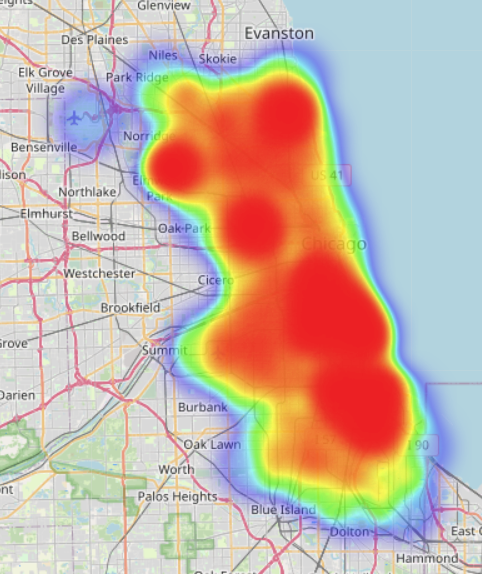

In [68]:
# 4. Job Flow Heatmap (Employment Centers vs. Transit Hubs)
flow_map = folium.Map(location=[41.8781, -87.6298], zoom_start=11)
job_heat_data = employment_with_geo[['Latitude', 'Longitude']].dropna().values.tolist()
HeatMap(job_heat_data, radius=30).add_to(flow_map)
flow_map.save("job_flow_heatmap.html")
Image(filename="job_flow_heatmap.png")

/cvmfs/cybergis.illinois.edu/software/conda/cybergisx/python3-0.9.4/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


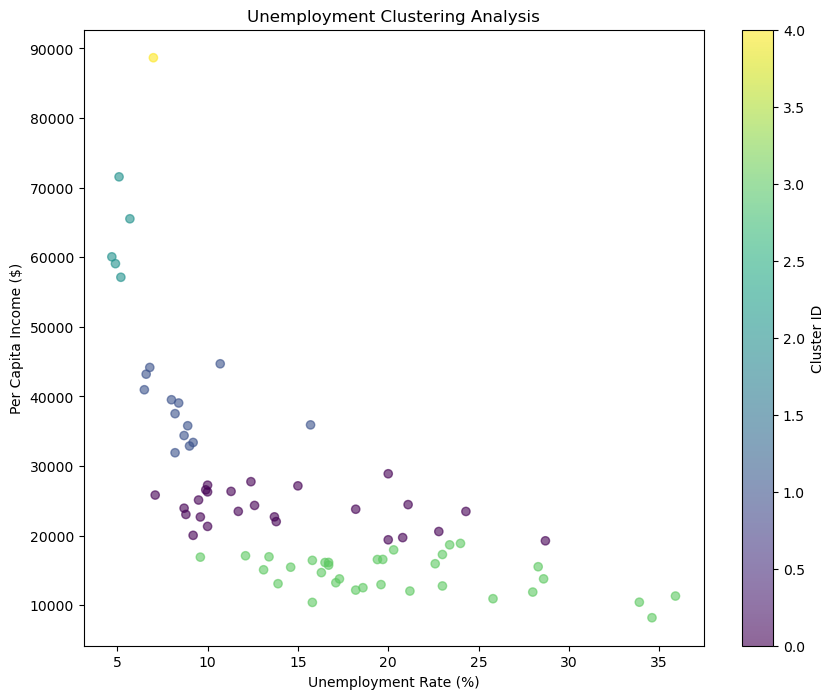

In [53]:
# 5. Unemployment Clustering Near Transit Hubs using K-Means
num_clusters = 5
employment_numeric = employment_with_geo[['Unemployment Rate', 'PER CAPITA INCOME']].dropna()
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(employment_numeric)
employment_with_geo['Cluster'] = kmeans.labels_
fig, ax = plt.subplots(figsize=(10,8))
scatter = ax.scatter(employment_with_geo['Unemployment Rate'], employment_with_geo['PER CAPITA INCOME'], c=employment_with_geo['Cluster'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cluster ID')
plt.xlabel("Unemployment Rate (%)")
plt.ylabel("Per Capita Income ($)")
plt.title("Unemployment Clustering Analysis")
plt.savefig("unemployment_clustering.png")